# Logistic Regression with TensorFlow

1. What is different between Linear and LogisticRegression
2. Utilizing Logistice Regerssion with TensorFlow
3. Training the model



### 1. What is the difference between Linear and Logistic Regression

While Linear Regression is suited for estimating continuous values (e.g. estimating house price), it is not the best tool for predicting the class in which an observed data point belongs. In order to provide estimate for classification, we need some sort of guidance on what would be the most probable class for that data point. For this, we use Logistic Regression.

Logistic Regression is a variation of Linear Regression, useful when the observed dependent variable, y, is categorical. It produces a formula that predicts the probability of the class label as a function of the independent variables.

Despite the name logistic regression, it is actually a probabilistic classification model. Logistic regression fits a special s-shaped curve by taking the linear regression and transforming the numeric estimate into a probability with the following function:

$ProbabilityofaClass = θ(y) = \frac{e^y}{1+e^y} = exp(y)$

which produces p-values between 0 (as y approaches minus infinity  −∞ ) and 1 (as y approaches plus infinity  +∞ ). This now becomes a special kind of non-linear regression.

In this equation, $y$ is the regression result (the sum of the variables weighted by the coefficients), $exp$ is the exponential function and  $𝜃(𝑦)$  is the logistic function, also called logistic curve. It is a common "S" shape (sigmoid curve), and was first developed for modeling population growth.

You might also have seen this function before, in another configuration:

$Probability of a class = θ(y) = \frac{1}{1 + e^{-y}}$

So, briefly, Logistic Regression passes the input through the logistic/sigmoid function but then treats the result as a probability:

<img src="https://ibm.box.com/shared/static/kgv9alcghmjcv97op4d6onkyxevk23b1.png" width="400" align="center">

### 2. Utilizing Logistic Regression in TensorFlow

Let's import the required libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Understanding the dataset**

**Attributes Independent variable**
* Petal length
* Petal width
* sepal length
* sepal width

**Dependent variable**
* Species = {iris setosa, iris virginica, iris versicolor}

In [ ]:
iris = load_iris()
x_iris, y_iris = iris.data[:-1, :], iris.target[:-1]
y_iris = pd.get_dummies(y_iris).values
x_train, x_test, y_train, y_test = train_test_split(x_iris, y_iris, test_size = 0.3, random_state = 42)

Now we define x and y. These variables will hold our iris data (both the features and label matrices) We also need to give them shapes which correspond to the shape of our data.

In [ ]:
num_features = x_train.shape[1]
num_labels = y_train.shape[1]
print("The number of features: ", num_features)
print("The number of classes: ", num_labels)

The number of features:  4
The number of classes:  3


In [ ]:
x_train = tf.constant(x_train, dtype = "float32")
y_train = tf.constant(y_train, dtype = "float32")
x_test = tf.constant(x_test, dtype = "float32")
y_test = tf.constant(y_test, dtype = "float32")

**Set model wiights and bias**

Much like Linear Regression, we need a shared variable weight matrix for Logistic Regression. We initialize both `W `and `b` as tensors full of zeros. Since we are going to learn `W` and `b`, their initial value does not matter too much. These variables are the objects which define the structure of our regression model, and we can save them after they have been trained so we can reuse them later.

We define two TensorFlow variables as our parameters. These variables will hold the weights and biases of our logistic regression and they will be continually updated during training.

Notice that `W` has a shape of `[4, 3]` because we want to multiply the 4-dimensional input vectors by it to produce 3-dimensional vectors of evidence for the difference classes. `b` has a shape of `[3]` so we can add it to the output. TensorFlow variables need to be initialized with values, e.g. with zeros.

In [ ]:
W = tf.Variable(tf.zeros([4, 3]))
b = tf.Variable(tf.zeros([3]))

Randomly sample from a normal distribution with standard deviation .01


In [ ]:
weights = tf.Variable(tf.random.normal([num_features, num_labels], 
                                       mean = 0, 
                                       stddev = 0.01,
                                       name = "weigths"), dtype = "float32")

bias = tf.Variable(tf.random.normal([1, num_labels], 
                                       mean = 0, 
                                       stddev = 0.01,
                                       name = "bias"), dtype = "float32")

#### Logistic Regrerssion model

We now define our operations in order to properly run the Logistic Regression. Logistic regression is typically thought of as a single equation:

$\hat{y} = sigmoid(WX + b)$

However, for the sake of clarity, we can have it broken into its three main components:
* a weight times features matrix multiplication operation,
* a summation of the weighted features and a bias term,
* and finally the application of a sigmoid function.


In [ ]:
def h_logistic_regression(x):
  apply_weights_OP = tf.matmul(x, weights, name = "apply_weights")
  add_bias_OP = tf.add(apply_weights_OP, bias, name = "add_bias")
  activation_OP = tf.nn.sigmoid(add_bias_OP, name = "activation")
  return activation_OP

#### Training

The learning algorithm is how we search for the best weight vector ( 𝐰 ). This search is an optimization problem looking for the hypothesis that optimizes an error/cost measure

**Cost function**

Before defining our cost function, we need to define how long we are going to train and how should we define the learning rate.

In [ ]:
num_epochs = 700
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.0008, 
                                                               decay_steps = x_train.shape[0], 
                                                               decay_rate = 0.95, 
                                                               staircase = True)


What is the cost function in our model?
The cost function we are going to **utilize is the Squared Mean Error loss function**.

How to minimize the cost function?
We can't use least-squares linear regression here, so we will **use gradient descent instead**. Specifically, we will use batch gradient descent which calculates the gradient from all data points in the data set.

Defining the cost function - squared mean error

In [ ]:
loss_object =tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.SGD(learning_rate)

We also want some additional operations to keep track of our model's efficiency over time. We can do this like so:

In [ ]:
def accuracy(y_pred, y_true):
  """"
  Predicted class is the index of the highest score in prediction vector (i.e. argmax)
  """
  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We first wrap computation inside a GradientTape for automatic differentiation. Then we compute gradients and update W and b.

In [ ]:
def run_optimization(x, y):
  with tf.GradientTape() as GT:
    prediction = h_logistic_regression(x)
    loss = loss_object(prediction, y)
  gradients = GT.gradient(loss, [weights, bias])
  optimizer.apply_gradients(zip(gradients, [weights, bias]))

with the operations involved in the prediction phase (i.e. the logistic regression itself).

Now we can define and run the actual training loop, like this:

In [ ]:
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 1
diff = 1

for epoch in range(num_epochs):
  if epoch > 1 and diff < 0.0001:
    print(f"change in loss {diff}; convergence.")
    break
    
  else:
    #Training step
    run_optimization(x_train, y_train)

    #Report occasional stats
    if epoch % display_step == 0:
      epoch_values.append(epoch)

      pred = h_logistic_regression(x_test)
      new_loss = loss_object(pred, y_test)
      loss_values.append(new_loss)

      acc = accuracy(pred, y_test)
      accuracy_values.append(acc)

      diff = abs(new_loss - loss)
      loss = new_loss

      print(f"step: {epoch}, training accuracy: {acc}, loss: {new_loss}, change in loss: {diff}")

print("Final accuracy on test set: ", acc.numpy())

step: 0, training accuracy: 0.2888889014720917, loss: 0.10832977294921875, change in loss: 0.8916702270507812
step: 10, training accuracy: 0.2888889014720917, loss: 0.10829265415668488, change in loss: 3.711879253387451e-05
change in loss 3.711879253387451e-05; convergence.
Final accuracy on test set:  0.2888889


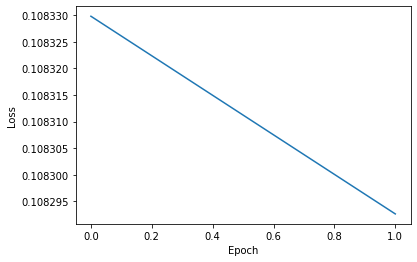

In [ ]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()